In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from timeseries import *
from models import *
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
from fastai.distributed import *
import neptune
from neptunecontrib.monitoring.fastai import NeptuneMonitor


/opt/anaconda/envs/pytorch/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [4]:
x, y = pickle.load(open("data/train.pkl", "rb"))

In [5]:
test_name, x_test = pickle.load(open("data/test.pkl", "rb"))

In [6]:
x.mean(), x.std(), x.min(), x.max()

(-6.63823368281504e-06, 79.22496224741775, -5831.451171875, 6120.92822265625)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42123456)

In [27]:
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1)
act_fn = 'relu'
nf = 64
bs = 64
pool = nn.AdaptiveAvgPool1d

# Model

In [28]:
import torch
import torch.nn as nn
from models.layers import *

class SeModule(nn.Module):
    def __init__(self, ch, reduction, act_fn='relu'):
        super().__init__()
        nf = math.ceil(ch//reduction/8)*8
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.conv1 = convlayer(ch, nf, 1, act_fn=act_fn)
        self.conv2 = convlayer(nf, ch, 1, act_fn=False)
        
    def forward(self, x):
        res = self.pool(x)
        res = self.conv1(res)
        res = self.conv2(res)
        res = nn.functional.sigmoid(res)
        return x * res
 
       
class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=[7, 5, 3], act_fn='relu'):
        super().__init__()
        self.conv1 = convlayer(ni, nf, ks[0], act_fn=act_fn)
        self.conv2 = convlayer(nf, nf, ks[1], act_fn=act_fn)
        self.conv3 = convlayer(nf, nf, ks[2], act_fn=False)
        self.se = SeModule(nf, 16, act_fn=act_fn)
        # expand channels for the sum if necessary
        self.shortcut = noop if ni == nf else convlayer(ni, nf, ks=1, act_fn=False)
        self.act_fn = get_act_layer(act_fn)

    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # Squeeze and Excitation
        x = self.se(x)
        # Shortcut
        sc = self.shortcut(res)
        # Residual
        x += sc
        x = self.act_fn(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self,c_in, c_out, nf=64, pool=nn.AdaptiveAvgPool1d, act_fn='relu'):
        super().__init__()
        self.block1 = ResBlock(c_in, nf, ks=[7, 5, 3], act_fn=act_fn)
        self.block2 = ResBlock(nf, nf * 2, ks=[7, 5, 3], act_fn=act_fn)
        self.block3 = ResBlock(nf * 2, nf * 2, ks=[7, 5, 3], act_fn=act_fn)
        self.gap = pool(1)
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x).squeeze(-1)
        return self.fc(x)

# Load Data

In [29]:
def _roll(x, max_shift_pct=0.7, direction=0):
    '''This roll'''
    if int(direction) not in [-1, 0, 1]: 
        raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
    direction = random.choice([-1, 1]) if direction == 0 else direction
    width = x.shape[-1]
    roll_by = int(width*random.random()*max_shift_pct*direction)
    if len(x.shape) < 2:
        sg = x.roll(roll_by)
    else:
        sg = torch.stack([ c.roll(roll_by) for c in x])
    return sg
TSRoll = TSTransform(_roll)

def _flip(x):
    '''This flip'''
    if random.random() < .5:
        return x.flip(-1)
    return x
TSFlip = TSTransform(_flip)

In [30]:
data = (ItemLists(Path("data"), TSList(x_train),TSList(x_val))
        .label_from_lists(y_train, y_val)
#         .transform(tfms=([TSFlip, TSRoll],[]))
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
    )

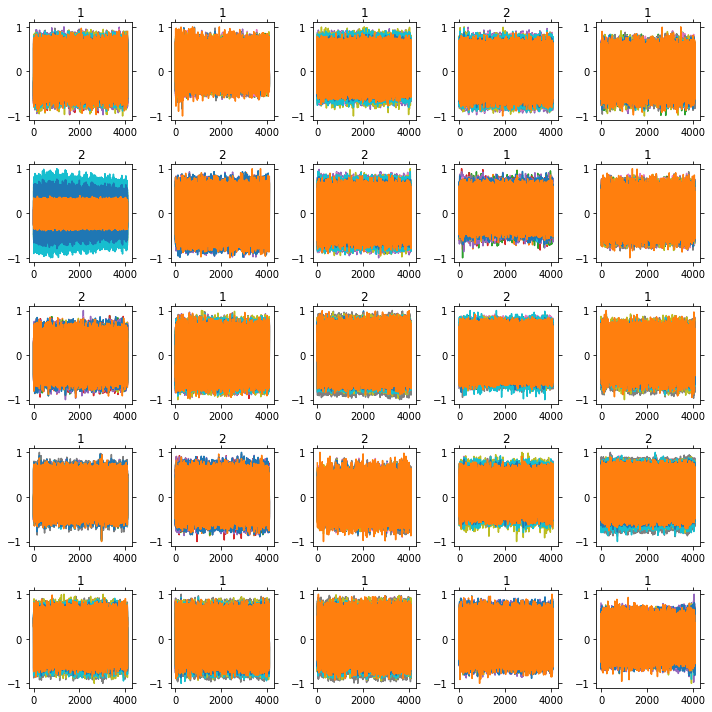

In [31]:
data.show_batch()

# Pretrained Weight

In [32]:
!aria2c --header "Host: ui.neptune.ai" --user-agent "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8" --header "Accept-Language: en-US,en;q=0.5" --header "DNT: 1" --referer "https://ui.neptune.ai/andrijdavid/ClinicalBrainComputerInterfacesChallenge2020/e/CBCIC2020-757/artifacts" --header "Cookie: neptune-vid=@npt--2abf4e73-aa79-4cd4-8d0c-488fe0b0c7ba; __stripe_mid=e717b1fd-b2da-4186-a12f-8fb2ae2075e4; neptune-uid=andrijdavid; neptune-ir=direct; __stripe_sid=1e37d361-94db-4f81-8978-b56e6ec6f4a1" --header "Upgrade-Insecure-Requests: 1" "https://ui.neptune.ai/api/leaderboard/v1/storage/download?experimentIdentifier=andrijdavid%2FClinicalBrainComputerInterfacesChallenge2020%2FCBCIC2020-757&pathParam=Gail.pth&resource=output&access_token=eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJFS1dvUkZhUGJVdGlwSHVmVVpmVzZYWm1VT2J1VmR2T28yQXNNTkpacHBzIn0.eyJleHAiOjE1OTE3MDcwNDUsImlhdCI6MTU5MTcwNTI0NSwiYXV0aF90aW1lIjoxNTkxNDczNjU0LCJqdGkiOiJiNDY5NThiYS04NWY3LTRkOGItOWZhZS0zZGI3YjJhZDFkYmUiLCJpc3MiOiJodHRwczovL3VpLm5lcHR1bmUuYWkvYXV0aC9yZWFsbXMvbmVwdHVuZSIsImF1ZCI6WyJicm9rZXIiLCJhY2NvdW50Il0sInN1YiI6ImY3OGIyMGRkLWE3NjgtNGMwOS04ZDQ4LWVhMDcxZWRiZmRkNyIsInR5cCI6IkJlYXJlciIsImF6cCI6Im5lcHR1bmUtZnJvbnRlbmQiLCJub25jZSI6ImUxZTdmNTA2LWVlNTItNGJiNy04ZTQ1LTEyNGIzYTJjZGJmZSIsInNlc3Npb25fc3RhdGUiOiIyMWVhYmE2Mi05YzRlLTQyODEtOTQ5MC0xMTM0MGI5MDk2ZjkiLCJhY3IiOiIwIiwiYWxsb3dlZC1vcmlnaW5zIjpbImh0dHA6Ly9sb2NhbGhvc3Q6ODAwMCoiLCJodHRwczovL2F1dGgubmVwdHVuZS5tbCIsImh0dHBzOi8vbmVwdHVuZS5tbC8qIiwiaHR0cHM6Ly9hcHAubmVwdHVuZS5tbC8qIiwiaHR0cDovL2xvY2FsaG9zdCIsImh0dHBzOi8vY29tbXVuaXR5Lm5lcHR1bmUubWwiLCJodHRwOi8vbG9jYWxob3N0OjgwMDAiLCJodHRwczovL25lcHR1bmUubWwiLCIvIiwiaHR0cDovL25lcHR1bmUubWwiLCJodHRwczovL2NvbW11bml0eS5uZXB0dW5lLm1sLyoiLCJodHRwOi8vbG9jYWxob3N0OjgwODIvKiIsImh0dHBzOi8vbmVwdHVuZS5haSIsImh0dHBzOi8vbmVwdHVuZS5haS8qIiwiaHR0cHM6Ly9hcHAubmVwdHVuZS5tbCIsImh0dHA6Ly9sb2NhbGhvc3Q6ODA4MiIsImh0dHBzOi8vYXV0aC5uZXB0dW5lLm1sLyoiLCJodHRwczovL3VpLm5lcHR1bmUubWwvKiIsImh0dHA6Ly9sb2NhbGhvc3QvKiIsIi8qIiwiaHR0cHM6Ly91aS5uZXB0dW5lLm1sIiwiaHR0cDovL25lcHR1bmUubWwvKiJdLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsibmVwdHVuZV93cml0ZSIsIm9mZmxpbmVfYWNjZXNzIiwibmVwdHVuZV9yZWFkIiwidW1hX2F1dGhvcml6YXRpb24iXX0sInJlc291cmNlX2FjY2VzcyI6eyJicm9rZXIiOnsicm9sZXMiOlsicmVhZC10b2tlbiJdfSwiYWNjb3VudCI6eyJyb2xlcyI6WyJtYW5hZ2UtYWNjb3VudCIsIm1hbmFnZS1hY2NvdW50LWxpbmtzIiwidmlldy1wcm9maWxlIl19fSwic2NvcGUiOiJvcGVuaWQiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJhbmRyaWpkYXZpZCIsImVtYWlsIjoiYW5kcmlqZGF2aWRAdHVrZS5zayIsIm5lcHR1bmVIb3N0IjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5tbCJ9.R8O-OZ09HUocGi4LNZciTCNUJp2chqAzqF89bhvsTWTstxufAzL3-6jQP8y_el6Gwde-yHT8gxx5oD0RZbY_0o9P8OIxcVHHVRUc_jbyKiD9RTD1csmWw6Ug0UrsBnd5SY8s8cdYesWDtD4j6Zkk9NlOAwacy6bgcYk9gXp4UHsTVX4GtDSlMT8Oc6Vkkdo1kFWINpVnAhCc99YO8-kEe7JgcZH5RV12726gpJs422zdYIxkQCXMyWfCnlUygPlxwSQQz0LnGnFvRrJUoJv217Nj24h2nm8i7oYMT--vkv6M9VS-3IhL7h5pymmzMj0rdx0AO89rULiP9j9ed3ahDA" --out "gael.pth"


06/09 14:27:10 [NOTICE] Downloading 1 item(s)

06/09 14:27:11 [NOTICE] Download complete: /home/andrijdavid/Clinical Brain Computer Interfaces Challenge/gael.pth

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
7392ff|OK  |    10MiB/s|/home/andrijdavid/Clinical Brain Computer Interfaces Challenge/gael.pth

Status Legend:
(OK):download completed.


In [33]:
!mv gael.pth data/models/gael.pth

# Training

In [34]:
model = ResNet(data.features, data.c, act_fn=act_fn, nf=nf, pool=pool)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa])

In [35]:
learn.load("gael")

Learner(data=TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,1,2,2
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
2,2,1,1,2
Path: .;

Test: None, model=ResNet(
  (block1): ResBlock(
    (conv1): Sequential(
      (0): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0

No transformation has been applied


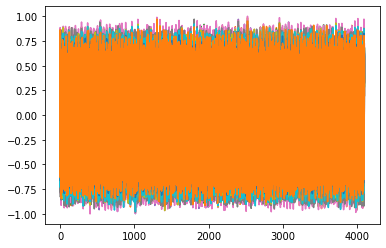

Learner(data=TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,1,2,2
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
2,2,1,1,2
Path: .;

Test: None, model=ResNet(
  (block1): ResBlock(
    (conv1): Sequential(
      (0): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0

In [36]:
learn.show_tfms()

In [37]:
learn.validate()

[0.24084494, tensor(0.9453), tensor(0.8902)]

In [54]:
def _resnet_split(m:nn.Module): return (m.block1, m.block2, m.block3, m.fc)
learn.split(_resnet_split)

Learner(data=TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,1,2,2
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
2,2,1,1,2
Path: .;

Test: None, model=ResNet(
  (block1): ResBlock(
    (conv1): Sequential(
      (0): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0

In [55]:
learn.freeze()

In [56]:
learn.layer_groups

[Sequential(
   (0): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
   (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
   (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
   (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU()
   (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
   (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): AdaptiveAvgPool1d(output_size=1)
   (9): Conv1d(64, 8, kernel_size=(1,), stride=(1,))
   (10): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU()
   (12): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
   (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): Conv1d(12, 64, kernel_size=(1,), stride=(1,))
   (15): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


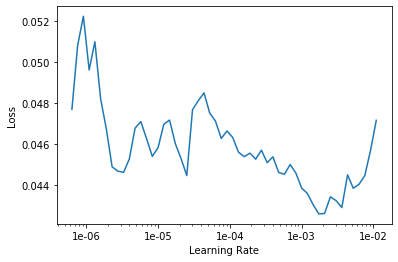

In [39]:
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(100, 1e-4)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.037222,0.242491,0.945312,0.890142,00:02
1,0.039764,0.241805,0.945312,0.890142,00:02
2,0.040261,0.241004,0.945312,0.890142,00:02
3,0.041722,0.241954,0.945312,0.890142,00:02
4,0.042296,0.242084,0.945312,0.890142,00:02
5,0.043283,0.243289,0.945312,0.890142,00:02
6,0.043072,0.240030,0.945312,0.890142,00:02
7,0.044369,0.237851,0.945312,0.890142,00:02
8,0.045296,0.244444,0.945312,0.890142,00:02
9,0.045323,0.244104,0.945312,0.890142,00:02


In [59]:
learn.save("gael-step2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


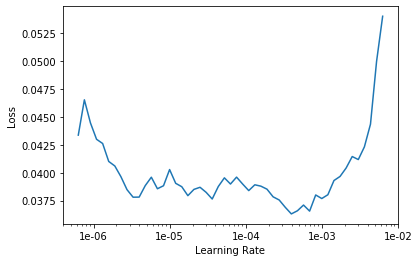

In [60]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(100, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.036681,0.243174,0.953125,0.905882,00:02
1,0.033075,0.242019,0.953125,0.905882,00:02
2,0.033153,0.241316,0.945312,0.890250,00:02
3,0.033798,0.245577,0.945312,0.890142,00:02
4,0.034085,0.245436,0.945312,0.890142,00:02
5,0.033867,0.242592,0.945312,0.890142,00:02
6,0.036902,0.246108,0.945312,0.890142,00:02
7,0.036878,0.242775,0.953125,0.905882,00:02
8,0.038108,0.242165,0.953125,0.905882,00:02
9,0.037490,0.239208,0.945312,0.890250,00:02


In [62]:
learn.fit_one_cycle(200, 1e-4)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.029926,0.249395,0.937500,0.874510,00:02
1,0.039982,0.252887,0.945312,0.890142,00:02
2,0.035127,0.249012,0.945312,0.890142,00:02
3,0.034404,0.253039,0.937500,0.874387,00:02
4,0.034164,0.252936,0.937500,0.874387,00:02
5,0.033843,0.249113,0.945312,0.890142,00:02
6,0.032361,0.248217,0.945312,0.890142,00:02
7,0.032971,0.254228,0.937500,0.874387,00:02
8,0.032007,0.251514,0.945312,0.890142,00:02
9,0.032062,0.249594,0.945312,0.890142,00:02


In [63]:
learn.save("gael-step3")

In [64]:
data = (ItemLists(Path("data"), TSList(x_train),TSList(x_val))
        .label_from_lists(y_train, y_val)
        .transform(tfms=([TSFlip, TSRoll],[]))
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
    )

In [65]:
learn.data = data

In [67]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.148216,0.311582,0.906250,0.811949,00:06
1,0.153267,0.306749,0.906250,0.811949,00:06
2,0.150264,0.291408,0.906250,0.811949,00:06
3,0.145640,0.297834,0.906250,0.811949,00:06
4,0.146856,0.301688,0.906250,0.811949,00:06
5,0.146550,0.293751,0.898438,0.796378,00:06
6,0.150630,0.305177,0.898438,0.796378,00:06
7,0.150972,0.315371,0.914062,0.827536,00:06
8,0.155673,0.307619,0.914062,0.827536,00:06
9,0.155606,0.302364,0.921875,0.843137,00:06


In [70]:
learn.TTA()

AttributeError: 'TSTransform' object has no attribute 'tfm'